In [ ]:
!pip install opencv-python
!pip install opencv-python-headless

In [ ]:

import requests
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from skimage.io import imread
from sklearn.model_selection import train_test_split

In [ ]:
import cv2, glob
import skimage
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline
from IPython.display import clear_output


In [ ]:
WEIGHTS_FOLDER = './model/'
if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

### image sources
- celeba-dataset
  - img_align_celeba/
    - img001.jpg
    - ...
  - list_attr_celeba.csv


In [ ]:
df_celeb = pd.read_csv('../input/celeba-dataset/list_attr_celeba.csv')

In [ ]:
df_celeb.shape

In [ ]:
df_celeb.head()

#### show sample image

In [ ]:
def show_sample_image(nb=3, df=df_celeb, verbose=True):
    '''
        Function picks random faces from the celebrity dataset, 
        It plots the faces and returns the last one including its metadata
        Args:
         df: dataframe with celebrity faces' metadata
         nb: number of faces to display
         verbose: if False, do not display the faces, only return the last face chosen.
        Output
         - an image of the last celebrity face selected
         - the metadata of the last celebrity face selected
    '''
    f, ax = plt.subplots(1, nb, figsize=(10,5))
    for i in range(nb):
        idx = random.randint(0, df.shape[0]-1)
        img_id = df.loc[idx].image_id
        img_uri = '../input/celeba-dataset/img_align_celeba/img_align_celeba/' + img_id
        img = skimage.io.imread(img_uri)  
        if verbose:
            label = img_id
            for col in df.columns:
                if df.loc[idx][col]==1:
                    label = label + '\n' + col  
            if nb > 1:
                ax[i].imshow(img)
                ax[i].set_title(label)
            else:
                ax.imshow(img) 
                ax.set_title(label)
        
    return img, list(df.loc[idx][1:df.shape[1]])

In [ ]:
import random
sample_img, sample_img_meta = show_sample_image()


In [ ]:
print('The images are {}px height, {}px width with {} color channels.'.format(sample_img.shape[0],sample_img.shape[1],sample_img.shape[2]))


#### masking practice

In [ ]:
import numpy as np
import cv2

def generate_random_block_mask(image, min_block_size=20, max_block_size=60):
    height, width, _ = image.shape
    mask = np.zeros((height, width), dtype=np.uint8)

    block_width = np.random.randint(min_block_size, max_block_size + 1)
    block_height = np.random.randint(min_block_size, max_block_size + 1)

    x1 = np.random.randint(0, width - block_width)
    y1 = np.random.randint(0, height - block_height)
    x2 = x1 + block_width
    y2 = y1 + block_height

    mask[y1:y2, x1:x2] = 1

    return mask

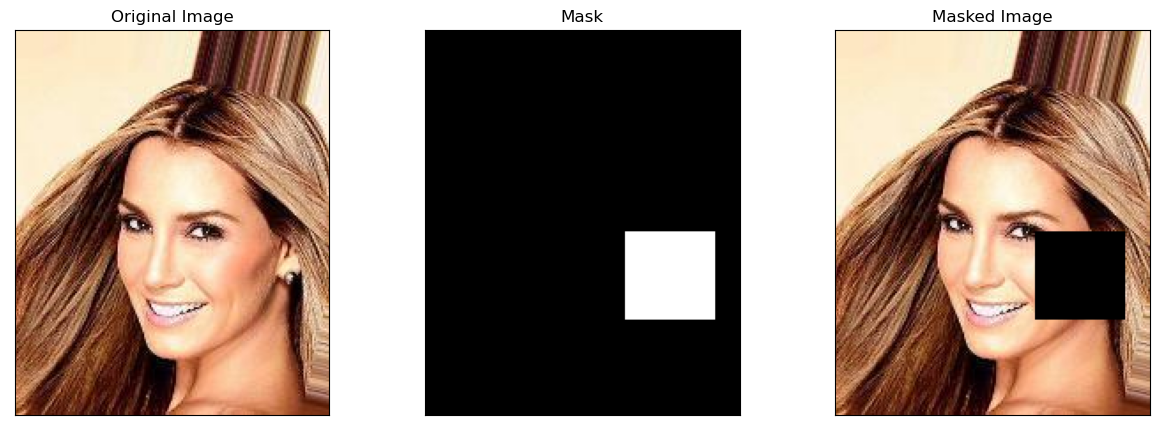

In [32]:
import cv2
import matplotlib.pyplot as plt

# Load an image from the CelebA dataset
image_path = "../input/celeba-dataset/img_align_celeba/img_align_celeba/000001.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Generate a random block mask for the image
mask = generate_random_block_mask(image)

# Apply the mask to the image
masked_image = image.copy()
masked_image[mask == 1] = 0

# Display the original image, mask, and masked image
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[1].imshow(mask, cmap="gray")
axs[1].set_title("Mask")
axs[2].imshow(masked_image)
axs[2].set_title("Masked Image")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

#### before training mask all images

In [12]:
# import os
# import cv2
# import random
# import numpy as np

# def random_block_mask(image, block_size=(64, 64)):
#     h, w, _ = image.shape
#     x = random.randint(0, w - block_size[0])
#     y = random.randint(0, h - block_size[1])
#     masked_image = image.copy()
#     masked_image[y:y + block_size[1], x:x + block_size[0]] = 0
#     return masked_image

# input_dir = "../input/celeba-dataset/img_align_celeba/img_align_celeba/"
# output_dir = "/kaggle/working/celeba-dataset/masked_images/"

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# for file_name in os.listdir(input_dir):
#     input_path = os.path.join(input_dir, file_name)
#     output_path = os.path.join(output_dir, file_name)

#     image = cv2.imread(input_path)

#     if image is not None:
#         masked_image = random_block_mask(image)
#         cv2.imwrite(output_path, masked_image)
#     else:
#         print(f"Image {input_path} not found or not loaded correctly.")

083648.jpg
168202.jpg


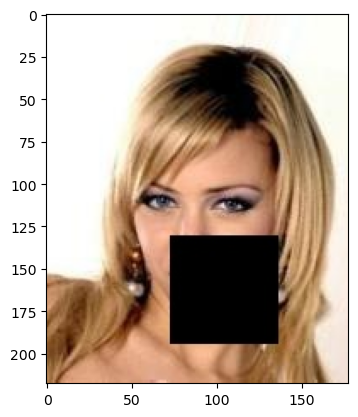

In [33]:
import cv2
import matplotlib.pyplot as plt

# Load an image from the CelebA dataset
image_path = '../input/celeba-dataset/img_align_celeba/img_align_celeba/'
mask_dir = "/kaggle/working/celeba-dataset/masked_images/"
for file_name in os.listdir(image_path)[:2]:
    print(file_name)
    image = cv2.imread(os.path.join(mask_dir, file_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)


#### Data Loader

In [34]:
import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from PIL import Image

class CelebADatasetWithPreGeneratedMasks(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = os.listdir(img_dir)
        self.masked_image_files = os.listdir(mask_dir)
        print(len(self.masked_image_files))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.image_files[idx])  # Assumes mask files have same names as image files
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("1")  # Loads the mask as binary (black and white)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Usage:
img_dir = "../input/celeba-dataset/img_align_celeba/img_align_celeba/"
mask_dir = "/kaggle/working/celeba-dataset/masked_images/"

celeba_dataset = CelebADatasetWithPreGeneratedMasks(img_dir, mask_dir, transform=ToTensor())

202599


In [35]:
from torch.utils.data import DataLoader, random_split

# Assuming your_dataset is an instance of your Dataset class
train_size = int(0.8 * len(celeba_dataset))  # Use 80% of the dataset for training
val_size = len(celeba_dataset) - train_size

train_dataset, val_dataset = random_split(celeba_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
validation_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np

# refer from https://github.com/jaxony/unet-pytorch/blob/master/model.py
def conv3x3(in_channels, out_channels, stride=1, 
            padding=1, bias=True, groups=1):    
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=2,
            stride=2)
    else:
        # out_channels is always going to be the same
        # as in_channels
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=1,
        groups=groups,
        stride=1)

def crop_tensors(t1, t2):
    _, _, h1, w1 = t1.size()
    _, _, h2, w2 = t2.size()
    h_crop, w_crop = min(h1, h2), min(w1, w2)

    t1_cropped = t1[:, :, :h_crop, :w_crop]
    t2_cropped = t2[:, :, :h_crop, :w_crop]

    return t1_cropped, t2_cropped

class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool

class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels, merge_mode='concat', up_mode='transpose'):
        super(UpConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        if up_mode == 'transpose':
            self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        elif up_mode == 'upsample':
            self.upconv = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
            )

        if merge_mode == 'concat':
            self.conv = nn.Conv2d(in_channels + out_channels, out_channels, kernel_size=3, padding=1)
        else:  # merge_mode == 'add'
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.pad = nn.ReflectionPad2d(1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, from_down, from_up):
        from_down = F.interpolate(from_down, size=from_up.shape[2:], mode='bilinear', align_corners=False)
        
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.bn(self.conv(x)))
        return x

    
class Generator(nn.Module):
    def __init__(self, num_classes, in_channels=3, depth=5, start_filts=64, up_mode='transpose', merge_mode='concat'):
        super(Generator, self).__init__()

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = in_channels if i == 0 else outs
            outs = start_filts * (2 ** i)
            pooling = True if i < depth - 1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth - 1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode, merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)
        return x

    
## refer from https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/pix2pix/models.py
# However, in the context of image inpainting, we usually have one input, which is the generated/completed image, or the real image for comparison. 
# so i modify the discriminator to accept a single input and process it accordingly. 
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True, stride=2):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=stride, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=False))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512, stride=1),  # Change stride to 1
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img):
        return self.model(img)

In [58]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
def evaluate_models(generator, discriminator_global, discriminator_local, validation_dataloader, criterion_adv, criterion_context, criterion_perceptual, vgg16):
    generator.eval()
    discriminator_global.eval()
    discriminator_local.eval()

    total_gen_loss = 0
    total_disc_global_loss = 0
    total_disc_local_loss = 0
    total_samples = 0

    with torch.no_grad():
        for images, masks in validation_dataloader:
            images = images.to(device)
            masks = masks.to(device)

            completed_images = generator(images * masks)

            real_labels = torch.ones(images.size(0), 1).to(device)
            fake_labels = torch.zeros(images.size(0), 1).to(device)

            global_real_output = discriminator_global(images)
            global_fake_output = discriminator_global(completed_images)

            local_real_output = discriminator_local(images * (1 - masks))
            local_fake_output = discriminator_local(completed_images * (1 - masks))

            loss_adv_global = criterion_adv(global_real_output, real_labels) + criterion_adv(global_fake_output, fake_labels)
            loss_adv_local = criterion_adv(local_real_output, real_labels) + criterion_adv(local_fake_output, fake_labels)
            loss_adv = loss_adv_global + loss_adv_local

            loss_context = criterion_context(completed_images * masks, images * masks)

            loss_perceptual = criterion_perceptual(vgg16(completed_images), vgg16(images))

            loss_generator = loss_adv + loss_context + loss_perceptual

            total_gen_loss += loss_generator.item()
            total_disc_global_loss += loss_adv_global.item()
            total_disc_local_loss += loss_adv_local.item()
            total_samples += images.size(0)

    mean_gen_loss = total_gen_loss / total_samples
    mean_disc_global_loss = total_disc_global_loss / total_samples
    mean_disc_local_loss = total_disc_local_loss / total_samples

    return mean_gen_loss, mean_disc_global_loss, mean_disc_local_loss

def evaluate_model_external(generator, dataloader):
    generator.eval()
    total_psnr = 0
    total_ssim = 0
    total_samples = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            completed_images = generator(images * masks)
            completed_images = completed_images.detach().cpu().numpy()
            original_images = images.detach().cpu().numpy()

            for i in range(images.size(0)):
                original_image = np.transpose(original_images[i], (1, 2, 0))
                completed_image = np.transpose(completed_images[i], (1, 2, 0))

                total_psnr += psnr(original_image, completed_image, data_range=1)
                total_ssim += ssim(original_image, completed_image, multichannel=True, data_range=1)

            total_samples += images.size(0)

    mean_psnr = total_psnr / total_samples
    mean_ssim = total_ssim / total_samples

    return mean_psnr, mean_ssim

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
import torchvision.models as models
import torchvision.transforms as transforms
generator = Generator(num_classes=3, in_channels=3, depth=5, start_filts=64, up_mode='transpose', merge_mode='concat')
discriminator_global = Discriminator(in_channels=3)
discriminator_local = Discriminator(in_channels=3)

criterion = nn.BCELoss()
criterion_adv = nn.BCEWithLogitsLoss()
criterion_context = nn.L1Loss()

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_discriminator_global = torch.optim.Adam(discriminator_global.parameters(), lr=0.0002)
optimizer_discriminator_local = torch.optim.Adam(discriminator_local.parameters(), lr=0.0002)
criterion_perceptual = nn.L1Loss()


In [70]:
def vgg16_no_inplace(pretrained=True):
    model = models.vgg16(pretrained=pretrained)
    layers = list(model.features.children())
    for i, layer in enumerate(layers):
        if isinstance(layer, nn.ReLU):
            layers[i] = nn.ReLU(inplace=False)
    return nn.Sequential(*layers)


vgg16 = vgg16_no_inplace().to(device)
vgg16.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU()
  (19): Conv2d(512, 512, ke

In [71]:
generator = generator.to(device)
discriminator_global = discriminator_global.to(device)
discriminator_local = discriminator_local.to(device)
 

In [67]:
discriminator_local

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [21]:
# num_epochs = 100
# best_loss = float('inf')

# for epoch in range(num_epochs):
#     for i, (images, masks) in enumerate(train_dataloader):
#         images = images.to(device)
#         masks = masks.to(device)
        
#         # Train the generator and discriminators using the images and masks
#         # Implement the training algorithm according to the paper

#         # 1. Generate completed images using the generator (Completion Network)
#         completed_images = generator(images * masks)

#         # 2. Compute the adversarial loss for the generator using the global and local discriminators
#         real_labels = torch.ones(images.size(0), 1)
#         fake_labels = torch.zeros(images.size(0), 1)

#         upsample = nn.Upsample(size=(218, 178), mode='bilinear', align_corners=True)
#         upsample_masks = nn.Upsample(size=(218, 178), mode='nearest')
        
#         upsampled_completed_images = upsample(completed_images)
#         upsampled_masks = upsample_masks(1 - masks)

#         local_real_output = discriminator_local(images * upsampled_masks)
#         local_fake_output = discriminator_local(upsampled_completed_images * upsampled_masks)

#         global_real_output = discriminator_global(upsample(images))
#         global_fake_output = discriminator_global(upsampled_completed_images)

        
#         # Expand the real and fake labels to match the output size of the discriminators
#         real_labels_expanded = real_labels.view(real_labels.size(0), 1, 1, 1).expand_as(global_real_output)
#         fake_labels_expanded = fake_labels.view(fake_labels.size(0), 1, 1, 1).expand_as(global_fake_output)
#         real_labels_expanded = real_labels_expanded.to(device)
#         fake_labels_expanded = fake_labels_expanded.to(device)
#         loss_adv_global = criterion_adv(global_real_output, real_labels_expanded) + criterion_adv(global_fake_output, fake_labels_expanded)
#         loss_adv_local = criterion_adv(local_real_output, real_labels_expanded) + criterion_adv(local_fake_output, fake_labels_expanded)
#         loss_adv = loss_adv_global + loss_adv_local
        
#         # 3. Compute the contextual loss by measuring the L1 distance between the original and completed images
#         expanded_masks = masks.expand_as(images)
#         loss_context = criterion_context(upsampled_completed_images * expanded_masks, images * expanded_masks)

#         # 4. Compute the perceptual loss using the VGG-16 network
#         completed_images = F.interpolate(completed_images, size=(224, 224), mode='bilinear', align_corners=False)
#         images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)

#         loss_perceptual = criterion_perceptual(vgg16(completed_images), vgg16(images))

#         # 5. Compute the contextual loss
#         # Resize images and completed_images to be at least (224x224)
#         images = F.interpolate(images, size=(224, 224))
#         completed_images = F.interpolate(completed_images, size=(224, 224))

#         # Compute the perceptual loss using the resized images
#         loss_perceptual = criterion_perceptual(vgg16(images), vgg16(completed_images))


#         # 6. Compute the combined loss for the generator (adversarial, contextual, and perceptual losses)
#         loss_combined = loss_adv + loss_contextual + loss_perceptual

#         # 7. Update the weights of the global and local discriminators using their respective adversarial losses
#         optimizer_discriminator_global.zero_grad()
#         loss_adv_global.backward()
#         optimizer_discriminator_global.step()

#         optimizer_discriminator_local.zero_grad()
#         loss_adv_local.backward()
#         optimizer_discriminator_local.step()

#         # 8. Update the generator's weights
#         optimizer_generator.zero_grad()
#         loss_combined.backward()  # Call .backward() on the combined loss
#         optimizer_generator.step()
#     # Evaluation
#     # Inside your training loop, after each epoch
#     val_gen_loss, val_disc_global_loss, val_disc_local_loss = evaluate_models(generator, discriminator_global, discriminator_local, validation_dataloader, criterion_adv, criterion_context, criterion_perceptual, vgg16)
#     print(f"Epoch: {epoch}, Validation Losses - Generator: {val_gen_loss:.4f}, Discriminator Global: {val_disc_global_loss:.4f}, Discriminator Local: {val_disc_local_loss:.4f}")
#     val_psnr, val_ssim = evaluate_model_external(generator, validation_dataloader)
#     print(f"Epoch: {epoch}, Validation PSNR: {val_psnr:.4f}, SSIM: {val_ssim:.4f}")
#     # Update the best loss and save the model if necessary
    
#     if val_gen_loss < best_loss:
#         best_loss = val_gen_loss
#         best_generator = deepcopy(generator.state_dict())
#         best_discriminator_global = deepcopy(discriminator_global.state_dict())
#         best_discriminator_local = deepcopy(discriminator_local.state_dict())
#         # Save the best models
#         torch.save(best_generator, os.path.join(save_path, 'generator.pth'))
#         torch.save(best_discriminator_global, os.path.join(save_path, 'discriminator_global.pth'))
#         torch.save(best_discriminator_local, os.path.join(save_path, 'discriminator_local.pth'))

#         counter = 0
#     else:
#         counter += 1

#     # Check for early stopping
#     if counter >= patience:
#         print("Early stopping triggered.")
#         break


In [72]:
num_epochs = 100
best_loss = float('inf')

upsample = nn.Upsample(size=(218, 178), mode='bilinear', align_corners=True)
upsample_masks = nn.Upsample(size=(218, 178), mode='nearest')
torch.autograd.set_detect_anomaly(True)
for epoch in range(num_epochs):
    for i, (images, masks) in enumerate(train_dataloader):
        # Resize the images and masks to a consistent size
        
        images = images.to(device)
        masks = masks.to(device)
        
        # Train the generator and discriminators using the images and masks
        # Implement the training algorithm according to the paper
    
        # 1. Generate completed images using the generator (Completion Network)

        completed_images = generator(images * masks)
 
        # 2. Compute the adversarial loss for the generator using the global and local discriminators
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        upsampled_completed_images = upsample(completed_images)
        upsampled_masks = upsample_masks(1 - masks)

        local_real_output = discriminator_local(images * upsampled_masks)
        local_fake_output = discriminator_local(upsampled_completed_images * upsampled_masks)

        global_real_output = discriminator_global(upsample(images))
        global_fake_output = discriminator_global(upsampled_completed_images)

        
        # Expand the real and fake labels to match the output size of the discriminators
        real_labels_expanded = real_labels.view(real_labels.size(0), 1, 1, 1).expand_as(global_real_output).clone()
        fake_labels_expanded = fake_labels.view(fake_labels.size(0), 1, 1, 1).expand_as(global_fake_output).clone()
        
        real_labels_expanded = real_labels_expanded.to(device)
        fake_labels_expanded = fake_labels_expanded.to(device)
        
        loss_adv_global = criterion_adv(global_real_output, real_labels_expanded) + criterion_adv(global_fake_output, fake_labels_expanded)
        loss_adv_local = criterion_adv(local_real_output, real_labels_expanded) + criterion_adv(local_fake_output, fake_labels_expanded)
        loss_adv = loss_adv_global + loss_adv_local
        
        # 3. Compute the contextual loss by measuring the L1 distance between the original and completed images
        expanded_masks = masks.expand_as(images)
        loss_context = criterion_context(upsampled_completed_images * expanded_masks, images * expanded_masks)

        # 4. Compute the perceptual loss using the VGG-16 network
        # Resize completed_images and images to be compatible with VGG-16
        completed_images = F.interpolate(completed_images, size=(224, 224), mode='bilinear', align_corners=False)
        images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)

        loss_perceptual = criterion_perceptual(vgg16(completed_images), vgg16(images))

        # 5. Update the weights of the generator using the combined loss (adversarial, contextual, and perceptual losses)
        loss_generator = loss_adv + loss_context + loss_perceptual
        optimizer_generator.zero_grad()
        loss_generator.backward(retain_graph=True)
        optimizer_generator.step()

        # 6. Update the weights of the global and local discriminators using their respective adversarial losses
        optimizer_discriminator_global.zero_grad()
        loss_adv_global.backward(retain_graph=True)

        optimizer_discriminator_local.zero_grad()
        loss_adv_local.backward()

        optimizer_discriminator_global.step()
        optimizer_discriminator_local.step()
    # Evaluation
    # Inside your training loop, after each epoch
    val_gen_loss, val_disc_global_loss, val_disc_local_loss = evaluate_models(generator, discriminator_global, discriminator_local, validation_dataloader, criterion_adv, criterion_context, criterion_perceptual, vgg16)
    print(f"Epoch: {epoch}, Validation Losses - Generator: {val_gen_loss:.4f}, Discriminator Global: {val_disc_global_loss:.4f}, Discriminator Local: {val_disc_local_loss:.4f}")
    val_psnr, val_ssim = evaluate_model_external(generator, validation_dataloader)
    print(f"Epoch: {epoch}, Validation PSNR: {val_psnr:.4f}, SSIM: {val_ssim:.4f}")
    # Update the best loss and save the model if necessary
    
    if val_gen_loss < best_loss:
        best_loss = val_gen_loss
        best_generator = deepcopy(generator.state_dict())
        best_discriminator_global = deepcopy(discriminator_global.state_dict())
        best_discriminator_local = deepcopy(discriminator_local.state_dict())
        # Save the best models
        torch.save(best_generator, os.path.join(save_path, 'generator.pth'))
        torch.save(best_discriminator_global, os.path.join(save_path, 'discriminator_global.pth'))
        torch.save(best_discriminator_local, os.path.join(save_path, 'discriminator_local.pth'))

        counter = 0
    else:
        counter += 1

    # Check for early stopping
    if counter >= patience:
        print("Early stopping triggered.")
        break


OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 15.90 GiB total capacity; 14.89 GiB already allocated; 17.75 MiB free; 14.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [73]:
torch.cuda.empty_cache()

In [ ]:
num_epochs = 100
best_loss = float('inf')
upsample = nn.Upsample(size=(218, 178), mode='bilinear', align_corners=True)
upsample_masks = nn.Upsample(size=(218, 178), mode='nearest')
for epoch in range(num_epochs):
    for i, (images, masks) in enumerate(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        # Train the generator and discriminators using the images and masks
        # Implement the training algorithm according to the paper

        # 1. Generate completed images using the generator (Completion Network)
        completed_images = generator(images * masks)

        # 2. Compute the adversarial loss for the generator using the global and local discriminators
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        
        
        upsampled_completed_images = upsample(completed_images)
        upsampled_masks = upsample_masks(1 - masks)

        local_real_output = discriminator_local(images * upsampled_masks)
        local_fake_output = discriminator_local(upsampled_completed_images * upsampled_masks)

        global_real_output = discriminator_global(upsample(images))
        global_fake_output = discriminator_global(upsampled_completed_images)

        
        # Expand the real and fake labels to match the output size of the discriminators
        real_labels_expanded = real_labels.view(real_labels.size(0), 1, 1, 1).expand_as(global_real_output)
        fake_labels_expanded = fake_labels.view(fake_labels.size(0), 1, 1, 1).expand_as(global_fake_output)
        real_labels_expanded = real_labels_expanded.to(device)
        fake_labels_expanded = fake_labels_expanded.to(device)
        loss_adv_global = criterion_adv(global_real_output, real_labels_expanded) + criterion_adv(global_fake_output, fake_labels_expanded)
        loss_adv_local = criterion_adv(local_real_output, real_labels_expanded) + criterion_adv(local_fake_output, fake_labels_expanded)
        loss_adv = loss_adv_global + loss_adv_local
        
        # 3. Compute the contextual loss by measuring the L1 distance between the original and completed images
        expanded_masks = masks.expand_as(images)
        loss_context = criterion_context(upsampled_completed_images * expanded_masks, images * expanded_masks)

        # 4. Compute the perceptual loss using the VGG-16 network
        # Resize completed_images and images to be compatible with VGG-16
        completed_images = F.interpolate(completed_images, size=(224, 224), mode='bilinear', align_corners=False)
        images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)

        loss_perceptual = criterion_perceptual(vgg16(completed_images), vgg16(images))

        # 5. Update the weights of the generator using the combined loss (adversarial, contextual, and perceptual losses)
        loss_generator = loss_adv + loss_context + loss_perceptual
        optimizer_generator.zero_grad()
        loss_generator.backward(retain_graph=True)
        optimizer_generator.step()

        # 6. Update the weights of the global and local discriminators using their respective adversarial losses
        optimizer_discriminator_global.zero_grad()
        loss_adv_global.backward(retain_graph=True)
        optimizer_discriminator_global.step()

        optimizer_discriminator_local.zero_grad()
        loss_adv_local.backward()
        optimizer_discriminator_local.step()
    # Evaluation
    # Inside your training loop, after each epoch
    val_gen_loss, val_disc_global_loss, val_disc_local_loss = evaluate_models(generator, discriminator_global, discriminator_local, validation_dataloader, criterion_adv, criterion_context, criterion_perceptual, vgg16)
    print(f"Epoch: {epoch}, Validation Losses - Generator: {val_gen_loss:.4f}, Discriminator Global: {val_disc_global_loss:.4f}, Discriminator Local: {val_disc_local_loss:.4f}")
    val_psnr, val_ssim = evaluate_model_external(generator, validation_dataloader)
    print(f"Epoch: {epoch}, Validation PSNR: {val_psnr:.4f}, SSIM: {val_ssim:.4f}")
    # Update the best loss and save the model if necessary
    
    if val_gen_loss < best_loss:
        best_loss = val_gen_loss
        best_generator = deepcopy(generator.state_dict())
        best_discriminator_global = deepcopy(discriminator_global.state_dict())
        best_discriminator_local = deepcopy(discriminator_local.state_dict())
        # Save the best models
        torch.save(best_generator, os.path.join(save_path, 'generator.pth'))
        torch.save(best_discriminator_global, os.path.join(save_path, 'discriminator_global.pth'))
        torch.save(best_discriminator_local, os.path.join(save_path, 'discriminator_local.pth'))

        counter = 0
    else:
        counter += 1

    # Check for early stopping
    if counter >= patience:
        print("Early stopping triggered.")
        break
